<span style="font-size: 48px; font-weight: bold;">Algorytm SMAC testowany na zbiorze CIFAR-10</span>

Spis treści

- [1](#1)- Zainstalowanie wymaganych pakietów
- [2](#2) - Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow
- [3](#3) - Załadowanie danych
- [4](#4) - Ocena zbalansowania zbioru
- [5](#5) - Normalizacja danych
- [6](#6)- Zdefiniowanie CNN
- [7](#7) - Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametrów na liście
- [8](#8) - Zdefiniowa funkcji celu
- [9](#9) - Zdefiniowanie parametrów startowych
- [10](#10) - Wykonanie proces optymalizacji bayesowskiej za pomocą funkcji forest_optimize
- [11](#11) - Wyświetlenie najlepszych wyników
- [12](#12) - Wykres konwergencji
- [13](#13) - Wykres wartość funkcji celu w każdej iteracji
- [14](#14) - Wykres plot_objective
- [15](#15) - Wykres plot evaluations
- [16](#16) - Macierz pomyłek
- [17](#17) - Ocena modelu na zbiorze testowym

### <a name='1'></a> 1. Zainstalowanie wymaganych pakietów

In [1]:
# !pip install scikit-learn
# !pip install scikit-optimize
# !pip install keras
# !pip install numpy

### <a name="2"></a> 2. Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow

In [2]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D,MaxPooling2D, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from skopt import forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

import tensorflow as tf
from tensorflow.keras.datasets import cifar10

In [3]:
import time

### <a name="3"></a> 3.Załadowanie danych


In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:
y_train = y_train.flatten() 
y_test = y_test.flatten()

### <a name="4"></a> 4.Ocena zbalansowania zbioru

Text(0, 0.5, 'Number of images')

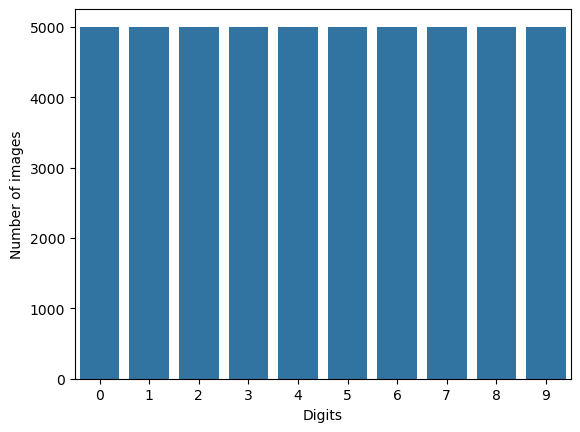

In [6]:
g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

### <a name="5"></a> 5. Normalizacja danych

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0


y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

### <a name="6"></a> 6.Zdefiniowanie CNN

In [8]:
def create_cnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    num_conv_layers,
    filter_size,
    kernel_size,
    activation,
):
    """
    Hiperparametry:
    learning_rate: Współczynnik uczenia dla optymalizatora.
    num_dense_layers: Liczba warstw gęstych (dense).
    num_dense_nodes: Liczba neuronów w każdej warstwie gęstej.
    num_conv_layers: Liczba warstw konwolucyjnych
    filter_size: Liczba filtrów w warstwach konwolucyjnych.
    kernel_size: Rozmiar kernela.
    activation: Funkcja aktywacji dla wszystkich warstw.
    """

    model = Sequential()

    
    for i in range(num_conv_layers):
        filters = filter_size + (15*i)
        model.add(Conv2D(kernel_size=kernel_size, strides=1, filters=filter_size, padding='same',
                     activation=activation))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Dropout(0.25))

    model.add(Flatten()) 

    for i in range(num_dense_layers):

        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))


    model.add(Dense(10, activation='sigmoid')) 
    
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

### <a name="7"></a> 7.Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametrów na liście

In [9]:
dim_learning_rate = Real(
    low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate',
)

dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')

dim_num_dense_nodes = Integer(low=10, high=500, name='num_dense_nodes')

dim_num_conv_layers = Integer(low=2, high=5, name='num_conv_layers')
dim_filter_size = Categorical(categories=[16, 32, 64, 128], name='filter_size')
dim_kernel_size = Categorical(categories=['(3,3)', '(5,5)', '(7,7)'], name='kernel_size')

dim_activation = Categorical(
    categories=['relu', 'sigmoid'], name='activation',
)


param_grid = [
    dim_learning_rate,
    dim_num_dense_layers,
    dim_num_dense_nodes,
    dim_num_conv_layers,
    dim_filter_size,
    dim_kernel_size,
    dim_activation,
]

### <a name="8"></a> 8.Zdefiniowa funkcji celu

In [10]:
# model zapisany pod nazwą
path_best_model = 'cnn_model.h5'

# punkt startowy dla optymalizacji
best_accuracy = 0


@use_named_args(param_grid)
def objective(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    num_conv_layers,
    filter_size,
    kernel_size,
    activation,
):

    """
    Hiperparametry:
    learning_rate: Współczynnik uczenia dla optymalizatora.
    num_dense_layers: Liczba warstw gęstych (dense).
    num_dense_nodes: Liczba neuronów w każdej warstwie gęstej.
    num_conv_layers: Liczba warstw konwolucyjnych
    filter_size: Liczba filtrów w warstwach konwolucyjnych.
    kernel_size: Rozmiar kernela.
    activation: Funkcja aktywacji dla wszystkich warstw.
    """

    if kernel_size == '(3,3)':
        kernel_size = (3,3)
    elif kernel_size == '(5,5)':
        kernel_size = (5,5)
    elif kernel_size == '(7,7)':
        kernel_size = (7,7)
        
    # drukowanie hiperparametrów
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('num_conv_layers:', num_conv_layers)
    print('filter_size:', filter_size)
    print('kernel_size:', kernel_size)
    print('activation:', activation)
    print()

    model = create_cnn(learning_rate=learning_rate,
                       num_dense_layers=num_dense_layers,
                       num_dense_nodes=num_dense_nodes,
                       num_conv_layers=num_conv_layers,
                       filter_size=filter_size,
                       kernel_size=kernel_size,
                       activation=activation)


    """
    Callback do redukcji współczynnika uczenia
    Automatycznie zmniejsza współczynnik uczenia (learning_rate) o factor=0.5, jeśli
    val_accuracy (dokładność na zbiorze walidacyjnym) nie poprawi się przez patience=2 epoki.
    Minimalny współczynnik uczenia to min_lr=0.00001."""
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                                patience=2,
                                                verbose=1,
                                                factor=0.5,
                                                min_lr=0.00001)

    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=5,
                        batch_size=32,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    accuracy = history.history['val_accuracy'][-1]

    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    global best_accuracy

    if accuracy > best_accuracy:
        model.save(path_best_model)

        best_accuracy = accuracy
    del model

    return -accuracy

### <a name="9 "></a> 9. Zdefiniowanie parametrów startowych

In [11]:
default_parameters = [1e-5, 1, 16,3,32,'(5,5)', 'relu']



### <a name="10"></a> 10. Wykonanie proces optymalizacji bayesowskiej za pomocą funkcji forest_optimize:

gdzie:
- **Przekazujemy:**
  - Funkcję celu (objective function),
  - Przestrzeń hiperparametrów (hyperparameter space),
  - Początkowe parametry: `x0` (lista z początkowymi wartościami hiperparametrów),
  - Funkcję akwizycji (acquisition function): domyślnie `"EI"` (Expected Improvement).
  - Liczbę próbek przestrzeni hiperparametrów: `n_calls=100`,
  - zmienną random_state ustawioną na 0 w celu reprodukowalności wyników


- **Cel:**
  Znalezienie optymalnych wartości hiperparametrów minimalizujących funkcję celu.

Biblioteka **skopt** wymaga określonej liczby punktów początkowych, które mogą być generowane losowo lub zdefiniowane w parametrze `x0`. 

Oprócz tego optymalizator wymaga dodatkowych wywołań do wyznaczania nowych punktów w przestrzeni hiperparametrów. Minimalna liczba wywołań to `n_calls >= 11`.

In [12]:
start_time = time.perf_counter() 
fm_ = forest_minimize(
    objective,  
    param_grid, 
    x0=default_parameters,  
    acq_func='EI', 
    n_calls=100,  
    random_state=0,
)
end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time} sekund")

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
num_conv_layers: 3
filter_size: 32
kernel_size: (5, 5)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.1142 - loss: 0.5690 - val_accuracy: 0.1768 - val_loss: 0.3555 - learning_rate: 1.0000e-05
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.1773 - loss: 0.3639 - val_accuracy: 0.2518 - val_loss: 0.3052 - learning_rate: 1.0000e-05
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.2348 - loss: 0.3188 - val_accuracy: 0.3008 - val_loss: 0.2852 - learning_rate: 1.0000e-05
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.2781 - loss: 0.3005 - val_accuracy: 0.3394 - val_loss: 0.2749 - learning_rate: 1.0000e-05
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.3089 - loss: 0.2898 - val_accuracy: 0.3654 - val_loss: 0.2667 - learning_rate: 1.0000e-05



Accuracy: 36.54%

learning rate: 2.4e-04
num_dense_layers: 1
num_dense_nodes: 333
num_conv_layers: 5
filter_size: 64
kernel_size: (5, 5)
activation: sigmoid

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.3742 - loss: 0.2866 - val_accuracy: 0.5254 - val_loss: 0.2134 - learning_rate: 2.3517e-04
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.6193 - loss: 0.1759 - val_accuracy: 0.6330 - val_loss: 0.1696 - learning_rate: 2.3517e-04
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.6960 - loss: 0.1453 - val_accuracy: 0.7120 - val_loss: 0.1388 - learning_rate: 2.3517e-04
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.7467 - loss: 0.1249 - val_accuracy: 0.6638 - val_loss: 0.1596 - learning_rate: 2.3517e-04
Epoch 5/5
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7823 - loss: 0.1089
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00011758406617445871.
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/


Accuracy: 68.16%

learning rate: 5.6e-05
num_dense_layers: 1
num_dense_nodes: 98
num_conv_layers: 2
filter_size: 32
kernel_size: (7, 7)
activation: sigmoid

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.2460 - loss: 0.3540 - val_accuracy: 0.4214 - val_loss: 0.2628 - learning_rate: 5.6279e-05
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.4289 - loss: 0.2569 - val_accuracy: 0.4642 - val_loss: 0.2397 - learning_rate: 5.6279e-05
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.4872 - loss: 0.2349 - val_accuracy: 0.5142 - val_loss: 0.2220 - learning_rate: 5.6279e-05
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.5245 - loss: 0.2197 - val_accuracy: 0.4762 - val_loss: 0.2374 - learning_rate: 5.6279e-05
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.5573 - loss: 0.2084 - val_accuracy: 0.5278 - val_loss: 0.2099 - learning_rate: 5.6279e-05

Accuracy: 52.78%

learning rate: 1.9e-04
num_d


Accuracy: 74.30%

learning rate: 2.7e-05
num_dense_layers: 1
num_dense_nodes: 408
num_conv_layers: 5
filter_size: 32
kernel_size: (5, 5)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.1789 - loss: 0.4684 - val_accuracy: 0.3686 - val_loss: 0.2704 - learning_rate: 2.7078e-05
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.3596 - loss: 0.2699 - val_accuracy: 0.4502 - val_loss: 0.2361 - learning_rate: 2.7078e-05
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.4460 - loss: 0.2387 - val_accuracy: 0.4996 - val_loss: 0.2169 - learning_rate: 2.7078e-05
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.4872 - loss: 0.2232 - val_accuracy: 0.5348 - val_loss: 0.2049 - learning_rate: 2.7078e-05
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.5215 - loss: 0.2107 - val_accuracy: 0.5630 - val_loss: 0.1974 - learning_rate: 2.7078e-05

Accuracy: 56.30%

learning rate: 9.0e-03
num_den


Accuracy: 74.48%

learning rate: 2.5e-04
num_dense_layers: 4
num_dense_nodes: 52
num_conv_layers: 5
filter_size: 128
kernel_size: (5, 5)
activation: sigmoid

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 81s 55ms/step - accuracy: 0.1207 - loss: 0.3815 - val_accuracy: 0.1666 - val_loss: 0.2992 - learning_rate: 2.4848e-04
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 77s 54ms/step - accuracy: 0.2105 - loss: 0.2894 - val_accuracy: 0.2552 - val_loss: 0.2774 - learning_rate: 2.4848e-04
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 76s 54ms/step - accuracy: 0.2810 - loss: 0.2717 - val_accuracy: 0.3274 - val_loss: 0.2626 - learning_rate: 2.4848e-04
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 76s 54ms/step - accuracy: 0.3378 - loss: 0.2569 - val_accuracy: 0.2692 - val_loss: 0.2952 - learning_rate: 2.4848e-04
Epoch 5/5
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3731 - loss: 0.2445
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00012424240412656218.
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 76s 54ms/


Accuracy: 74.50%

learning rate: 6.3e-06
num_dense_layers: 2
num_dense_nodes: 476
num_conv_layers: 3
filter_size: 128
kernel_size: (5, 5)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 77s 52ms/step - accuracy: 0.2447 - loss: 0.3543 - val_accuracy: 0.4506 - val_loss: 0.2407 - learning_rate: 6.3213e-06
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - accuracy: 0.4425 - loss: 0.2455 - val_accuracy: 0.5120 - val_loss: 0.2197 - learning_rate: 6.3213e-06
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - accuracy: 0.5024 - loss: 0.2248 - val_accuracy: 0.5532 - val_loss: 0.2074 - learning_rate: 6.3213e-06
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - accuracy: 0.5432 - loss: 0.2099 - val_accuracy: 0.5760 - val_loss: 0.1978 - learning_rate: 6.3213e-06
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - accuracy: 0.5680 - loss: 0.2002 - val_accuracy: 0.5920 - val_loss: 0.1902 - learning_rate: 6.3213e-06

Accuracy: 59.20%

learning rate: 8.3e-05
num_de


Accuracy: 76.72%

learning rate: 9.1e-04
num_dense_layers: 5
num_dense_nodes: 411
num_conv_layers: 3
filter_size: 128
kernel_size: (3, 3)
activation: relu

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 54s 36ms/step - accuracy: 0.4364 - loss: 0.2419 - val_accuracy: 0.4946 - val_loss: 0.2222 - learning_rate: 9.0636e-04
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - accuracy: 0.6711 - loss: 0.1543 - val_accuracy: 0.6522 - val_loss: 0.1609 - learning_rate: 9.0636e-04
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - accuracy: 0.7468 - loss: 0.1220 - val_accuracy: 0.7052 - val_loss: 0.1407 - learning_rate: 9.0636e-04
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 37ms/step - accuracy: 0.7904 - loss: 0.1032 - val_accuracy: 0.7226 - val_loss: 0.1375 - learning_rate: 9.0636e-04
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step - accuracy: 0.8289 - loss: 0.0855 - val_accuracy: 0.7654 - val_loss: 0.1230 - learning_rate: 9.0636e-04

Accuracy: 76.54%

learning rate: 1.3e-03
num_de

### <a name="11"></a> 11. Wyświetlenie najlepszych wyników

- **Dokładność (accuracy):** wyświetlenie najlepszej osiągniętej dokładności.
- **Najlepsze hiperparametry:** wyświetlenie optymalnych wartości hiperparametrów.
- **Przestrzeń poszukiwań (fm_space):** analiza przestrzeni hiperparametrów.

In [13]:
"Najlepsze dokładność=%.4f" % fm_.fun

'Najlepsze dokładność=-0.7672'

In [15]:
print("""Najlepsze hiperparametry:
=========================
- learning rate=%.6f
- num_dense_layers=%d
- num_nodes=%d
- num_conv_layers=%d
- num_filtes=%d
- kernel_size=%s
- activation = %s""" % (fm_.x[0],
                fm_.x[1],
                fm_.x[2],
                fm_.x[3],
                fm_.x[4],
                fm_.x[5],
                fm_.x[6]))

Najlepsze hiperparametry:
- learning rate=0.000652
- num_dense_layers=5
- num_nodes=494
- num_conv_layers=3
- num_filtes=128
- kernel_size=(3,3)
- activation = relu


In [16]:
fm_.space

Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='identity'),
       Integer(low=1, high=5, prior='uniform', transform='identity'),
       Integer(low=10, high=500, prior='uniform', transform='identity'),
       Integer(low=2, high=5, prior='uniform', transform='identity'),
       Categorical(categories=(16, 32, 64, 128), prior=None),
       Categorical(categories=('(3,3)', '(5,5)', '(7,7)'), prior=None),
       Categorical(categories=('relu', 'sigmoid'), prior=None)])

### <a name="12"></a> 12. Wykres konwergencji



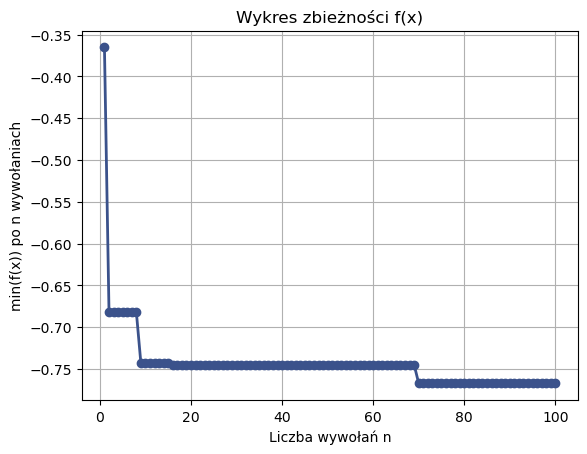

In [17]:
fig = plot_convergence(fm_)

plt.title("Wykres zbieżności f(x)")
plt.xlabel("Liczba wywołań n")
plt.ylabel("min(f(x)) po n wywołaniach")

fig.figure.savefig('wykres_zbieznosci.jpg', format='jpg', dpi=300)

plt.show()

In [18]:

iterations = range(len(fm_.func_vals))  
losses = fm_.func_vals               
cumulative_min = np.minimum.accumulate(losses)  


data_to_save = np.column_stack((iterations, losses, cumulative_min))

file_path = "convergence_data.txt"
np.savetxt(file_path, data_to_save, delimiter=',', header="Iteration,Loss,Cumulative_Min", fmt='%.6f', comments='')

print(f"Dane zapisano do pliku: {file_path}")

Dane zapisano do pliku: convergence_data.txt


### <a name="13"></a> 13. Wykres wartość funkcji celu w każdej iteracji

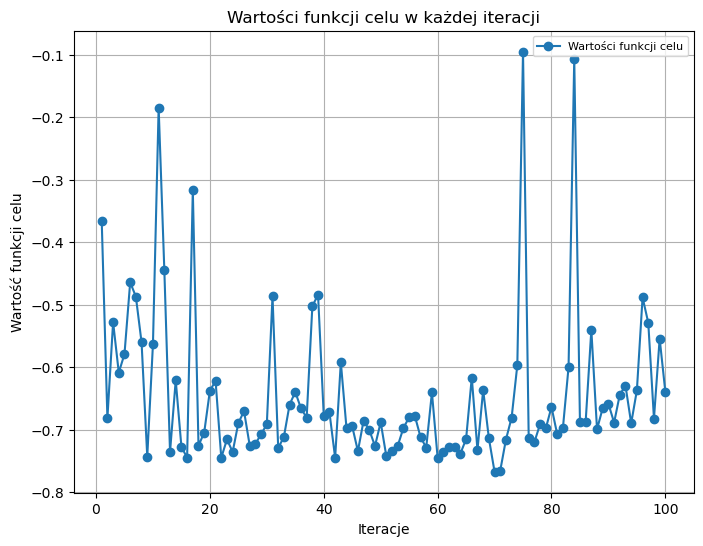

In [19]:

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(fm_.func_vals) + 1), fm_.func_vals, marker='o', label='Wartości funkcji celu')
plt.xlabel("Iteracje")
plt.ylabel("Wartość funkcji celu")
plt.title("Wartości funkcji celu w każdej iteracji")
plt.grid()
plt.legend(loc='upper right', fontsize=8)
plt.savefig('wyniki_funkcji_celu.png', dpi=300, bbox_inches='tight')

plt.show()

In [20]:

iterations = range(1, len(fm_.func_vals) + 1)  
losses = fm_.func_vals                        


data_to_save = np.column_stack((iterations, losses))


file_path = "function_values.txt"
np.savetxt(file_path, data_to_save, delimiter=',', header="Iteration,Loss", fmt='%d,%.6f', comments='')

print(f"Dane zapisano do pliku: {file_path}")

Dane zapisano do pliku: function_values.txt


### <a name="14"></a> 14.Wykres plot_objective

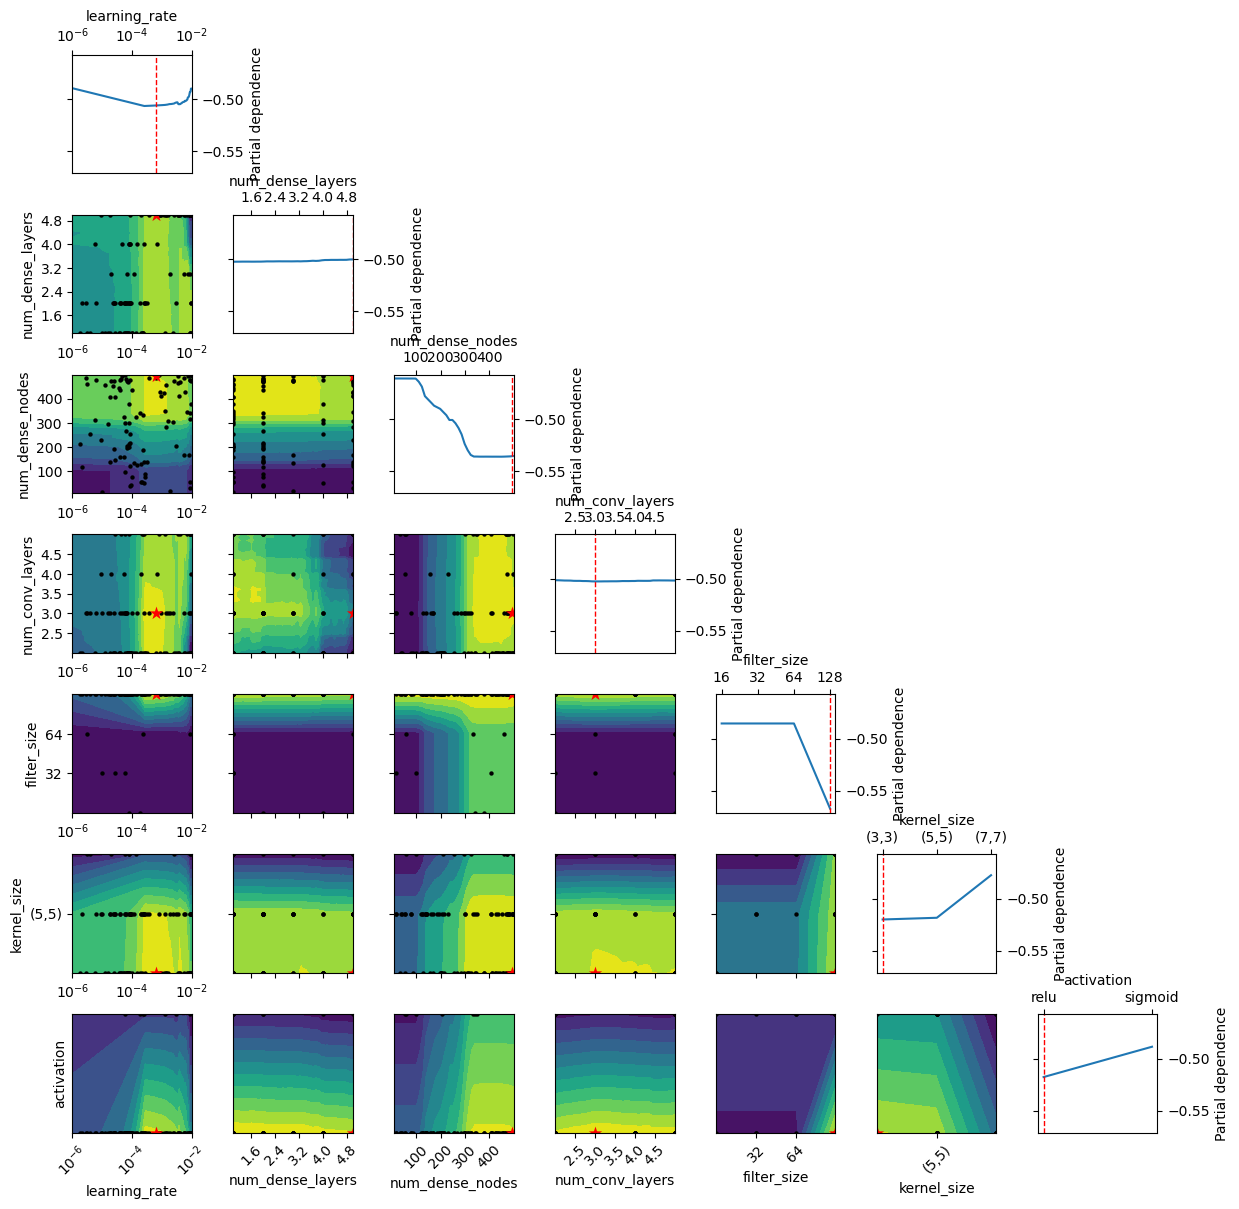

In [21]:
dim_names = [
    'learning_rate',
    'num_dense_layers',
    'num_dense_nodes',
    'num_conv_layers',
    'filter_size',
    'kernel_size',
    'activation'
]
fig2=plot_objective(result=fm_, plot_dims=dim_names)
plt.show()
fig2.figure.savefig('plot_objective.jpg', format='jpg', dpi=300)

### <a name="15"></a> 15.Wykres plot evaluations

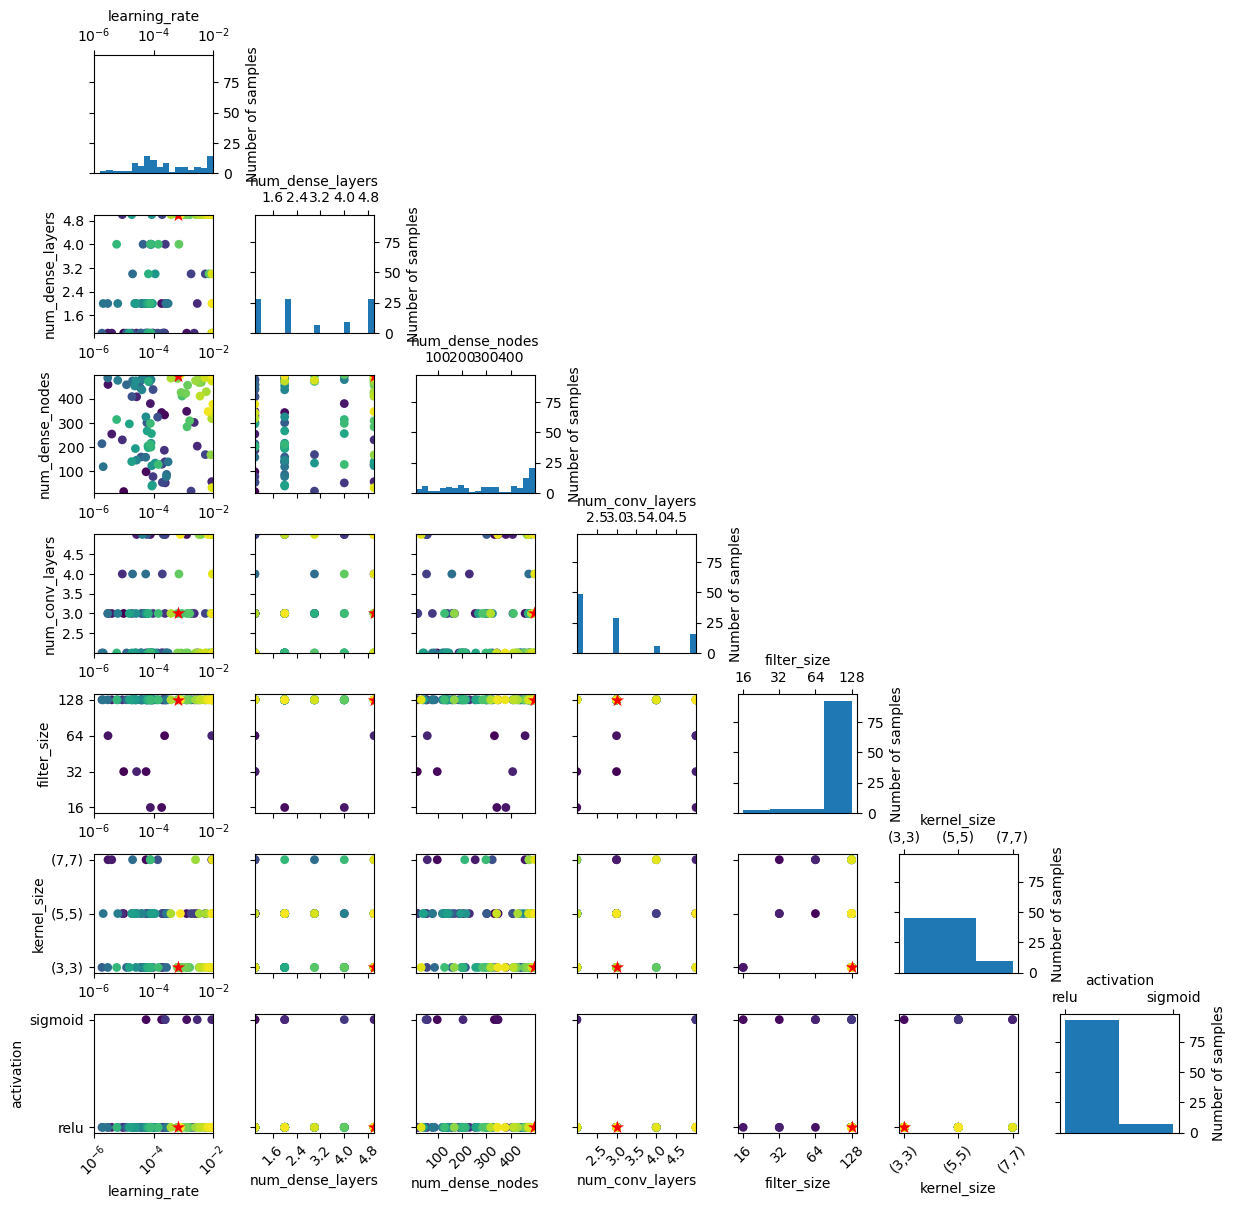

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [22]:
fig3=plot_evaluations(result=fm_, plot_dims=dim_names)
plt.show()
model = load_model('cnn_model.h5')
fig3.figure.savefig('plot_evaluations.jpg', format='jpg', dpi=300)
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis = 1)

y_true = np.argmax(y_test, axis = 1)

cm = confusion_matrix(y_true, y_pred_classes)



### <a name="16"></a> 16. Macierz pomyłek

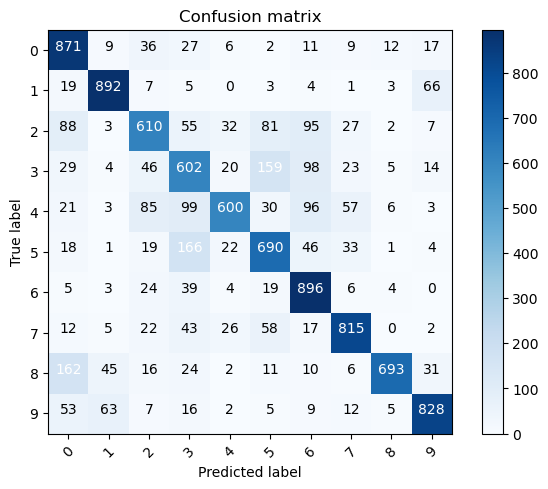

In [23]:

classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.jpg', format='jpg', dpi=300)

### <a name="17"></a> 17. Ocena modelu na zbiorze testowym

In [24]:

model = load_model('cnn_model.h5')
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7568 - loss: 0.1192
Test Loss: 0.12111145257949829
Test Accuracy: 0.7497000098228455
